Group genes based on the temporal shape of their expression or accessibility changes to identify shared dynamic patterns (e.g., early rise, brief drop). This highlights coordinated response behaviors beyond just magnitude, enabling deeper second-generation ensemble analysis.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [8]:
# ---- Updated Epsilon Computation ----
def compute_epsilon(values, percentile=5):
    diffs = np.concatenate([values[:, i+1] - values[:, i] for i in range(values.shape[1] - 1)])
    return np.percentile(np.abs(diffs), percentile)

# ---- Updated Direction Vector ----
def compute_temporal_directions(values, epsilon):
    dirs = []
    for i in range(1, len(values)):
        d = values[i] - values[i - 1]
        if np.isnan(d):
            dirs.append('na')
        elif d > epsilon:
            dirs.append('up')
        elif d < -epsilon:
            dirs.append('down')
        else:
            dirs.append('flat')
    return dirs

# ---- Updated Pattern Classification ----
def classify_temporal_pattern(dirs):
    n = len(dirs)
    transitions = sum(1 for i in range(1, n)
                      if dirs[i] != dirs[i-1] and 'na' not in [dirs[i], dirs[i-1]])

    if all(d == 'up' for d in dirs):
        return 'gradual up'
    elif all(d == 'down' for d in dirs):
        return 'gradual down'
    elif dirs.count('flat') >= n - 1:
        return 'flat'
    elif transitions >= 2:
        return 'fluctuating'
    elif dirs[:n//2].count('up') == 0 and dirs.count('up') >= 1:
        return 'late up'
    elif dirs[:n//2].count('down') == 0 and dirs.count('down') >= 1:
        return 'late down'
    else:
        return 'mixed'

# ---- Run Pattern Extraction ----
def run_temporal_shape(df, cols, epsilon):
    df_ = df.copy()
    df_['dir'] = df_[cols].apply(lambda row: compute_temporal_directions(row.values, epsilon), axis=1)
    df_['pattern'] = df_['dir'].apply(classify_temporal_pattern)
    return df_[['gene_name', 'pattern']]

# ---- Main Pipeline ----
def extract_temporal_value_trend_updated(file_path):
    for chr_folder_name in os.listdir(file_path):
        chr_path = os.path.join(file_path, chr_folder_name)
        if not os.path.isdir(chr_path) or not chr_folder_name.startswith('chr'):
            continue

        df = pd.read_csv(f"{chr_path}/{chr_folder_name}_expr_acc_features.csv")
        expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
        acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
        all_cols = expr_cols + acc_cols

        df_filtered = df.dropna(subset=all_cols)
        print(f"{chr_folder_name}: Total genes: {len(df)}; Genes used: {len(df_filtered)}")

        # Compute epsilon thresholds
        expr_epsilon = compute_epsilon(df_filtered[expr_cols].values, percentile=5)
        acc_epsilon = compute_epsilon(df_filtered[acc_cols].values, percentile=5)

        # Get temporal shape patterns
        res_expr = run_temporal_shape(df_filtered, expr_cols, expr_epsilon)
        res_expr.rename(columns={'pattern': 'expression_pattern'}, inplace=True)

        res_acc = run_temporal_shape(df_filtered, acc_cols, acc_epsilon)
        res_acc.rename(columns={'pattern': 'accessibility_pattern'}, inplace=True)

        # Merge and construct combined pattern
        results = res_expr.merge(res_acc, on='gene_name')
        results["combined_pattern"] = results["expression_pattern"] + " & " + results["accessibility_pattern"]

        # Save
        out_path = f"{chr_path}/{chr_folder_name}_temporal_value_patterns.csv"
        results.to_csv(out_path, index=False)
        print(f"{chr_folder_name} data saved")

# Confirm code is ready
"Code updated and ready to run on your local environment."


# ---- Run ----
file_path = 'data/green_monkey/all_structure_files/'
extract_temporal_value_trend(file_path)


chr23: Total genes: 597; Genes used: 397
chr23 data saved
chr12: Total genes: 895; Genes used: 589
chr12 data saved
chr15: Total genes: 533; Genes used: 309
chr15 data saved
chr14: Total genes: 830; Genes used: 480
chr14 data saved
chr13: Total genes: 499; Genes used: 251
chr13 data saved
chr25: Total genes: 642; Genes used: 409
chr25 data saved
chr22: Total genes: 713; Genes used: 507
chr22 data saved
chr4: Total genes: 443; Genes used: 225
chr4 data saved
chr3: Total genes: 450; Genes used: 237
chr3 data saved
chr2: Total genes: 877; Genes used: 482
chr2 data saved
chr5: Total genes: 952; Genes used: 614
chr5 data saved
chr18: Total genes: 387; Genes used: 201
chr18 data saved
chr27: Total genes: 273; Genes used: 177
chr27 data saved
chr20: Total genes: 1596; Genes used: 1141
chr20 data saved
chr29: Total genes: 248; Genes used: 155
chr29 data saved
chr16: Total genes: 1415; Genes used: 960
chr16 data saved
chr10: Total genes: 772; Genes used: 479
chr10 data saved
chr28: Total genes:

Total genes: 1323; Genes used: 802


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


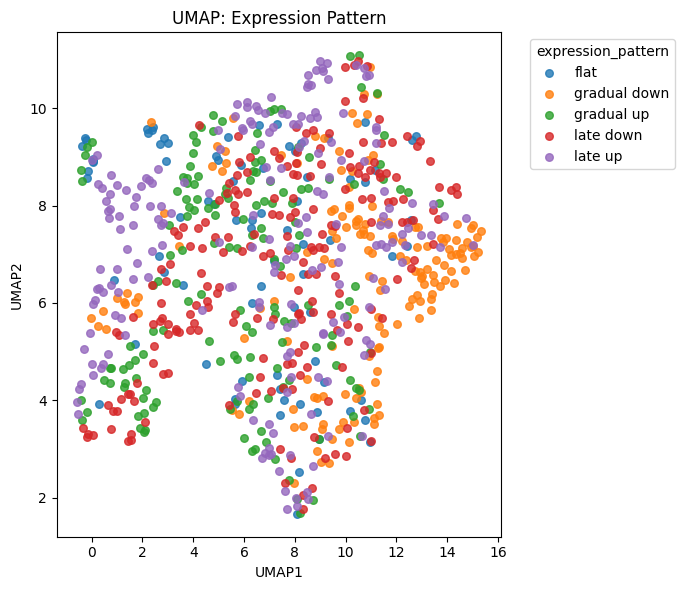

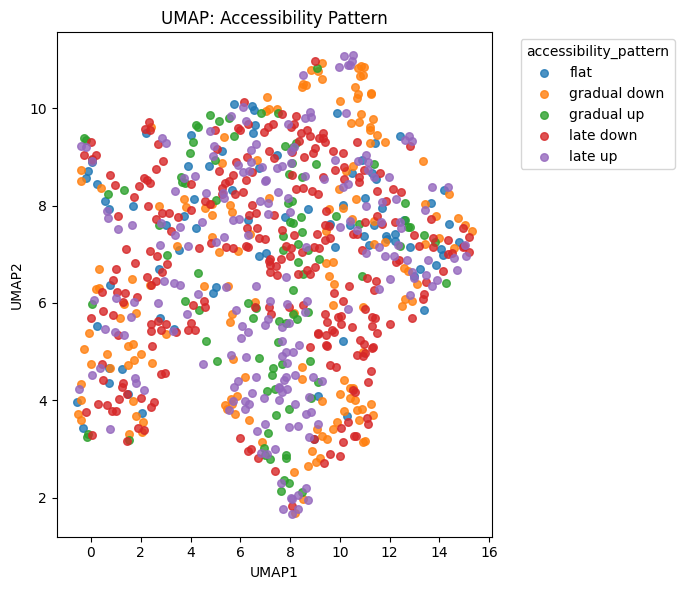

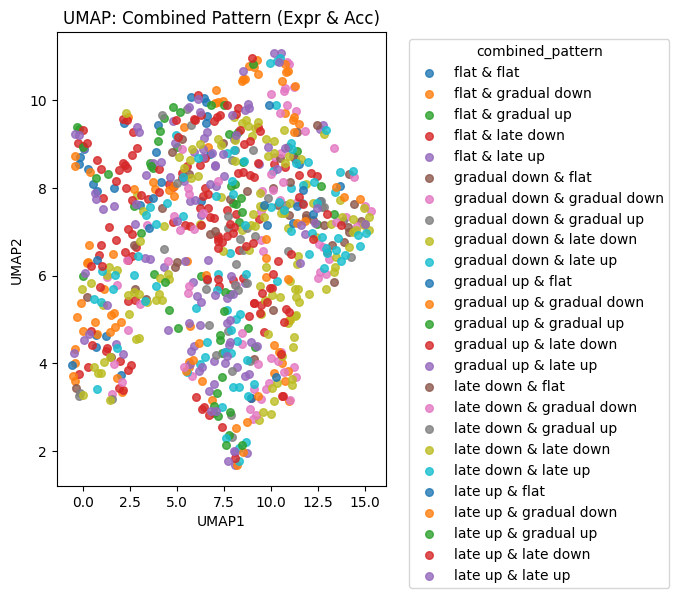

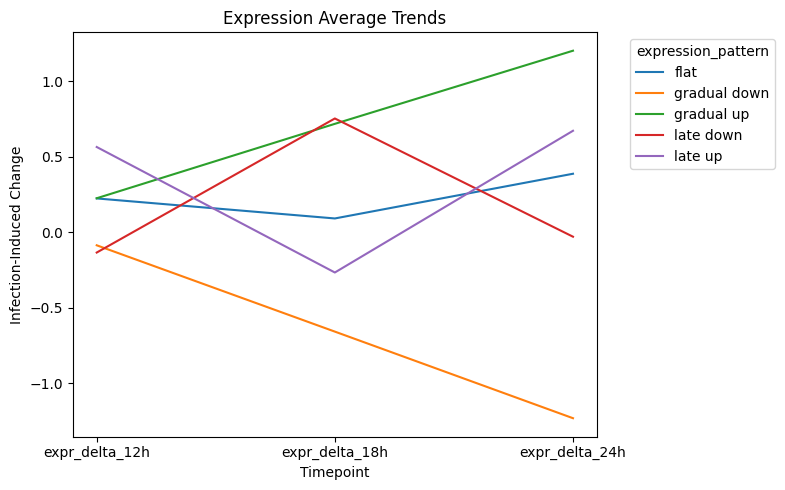

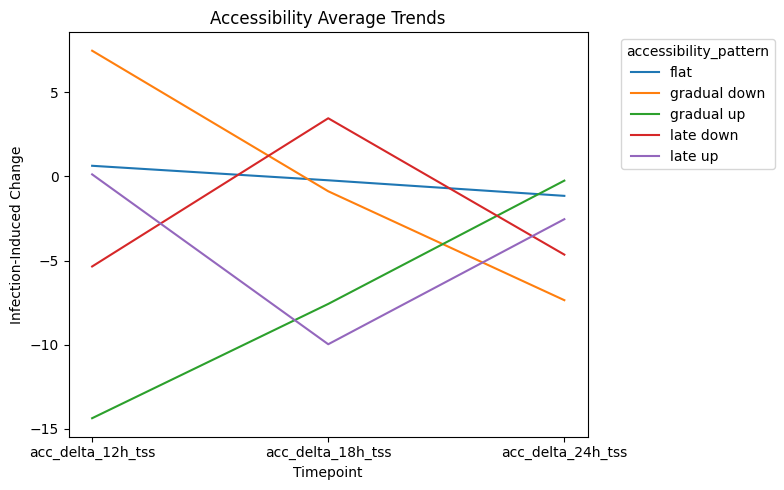

  gene_name expression_pattern accessibility_pattern        combined_pattern
2     BET1L            late up            gradual up    late up & gradual up
3     RIC8A          late down             late down   late down & late down
4     SIRT3            late up          gradual down  late up & gradual down
5    PSMD13            late up          gradual down  late up & gradual down
6     NLRP6               flat                  flat             flat & flat


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap

# ---- Load data ----
df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv")

expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
all_cols = expr_cols + acc_cols

df_filtered = df.dropna(subset=all_cols).copy()
print(f"Total genes: {len(df)}; Genes used: {len(df_filtered)}")

# ---- Epsilon computation ----
def compute_epsilon(values, percentile=5):
    diffs = np.concatenate([values[:, i+1] - values[:, i] for i in range(values.shape[1] - 1)])
    return np.percentile(np.abs(diffs), percentile)

expr_epsilon = compute_epsilon(df_filtered[expr_cols].values, percentile=5)
acc_epsilon = compute_epsilon(df_filtered[acc_cols].values, percentile=5)

# ---- Direction and pattern extraction ----
def compute_temporal_directions(values, epsilon):
    dirs = []
    for i in range(1, len(values)):
        d = values[i] - values[i - 1]
        if np.isnan(d):
            dirs.append('na')
        elif d > epsilon:
            dirs.append('up')
        elif d < -epsilon:
            dirs.append('down')
        else:
            dirs.append('flat')
    return dirs

def classify_temporal_pattern(dirs):
    n = len(dirs)
    transitions = sum(1 for i in range(1, n) if dirs[i] != dirs[i-1] and 'na' not in [dirs[i], dirs[i-1]])

    if all(d == 'up' for d in dirs):
        return 'gradual up'
    elif all(d == 'down' for d in dirs):
        return 'gradual down'
    elif dirs.count('flat') >= n - 1:
        return 'flat'
    elif transitions >= 2:
        return 'fluctuating'
    elif dirs[:n//2].count('up') == 0 and dirs.count('up') >= 1:
        return 'late up'
    elif dirs[:n//2].count('down') == 0 and dirs.count('down') >= 1:
        return 'late down'
    else:
        return 'mixed'

# ---- Apply to expression and accessibility ----
df_filtered['expr_dir'] = df_filtered[expr_cols].apply(lambda row: compute_temporal_directions(row.values, expr_epsilon), axis=1)
df_filtered['acc_dir'] = df_filtered[acc_cols].apply(lambda row: compute_temporal_directions(row.values, acc_epsilon), axis=1)

df_filtered['expression_pattern'] = df_filtered['expr_dir'].apply(classify_temporal_pattern)
df_filtered['accessibility_pattern'] = df_filtered['acc_dir'].apply(classify_temporal_pattern)
df_filtered['combined_pattern'] = df_filtered['expression_pattern'] + " & " + df_filtered['accessibility_pattern']

# ---- UMAP Embedding (all 6 features) ----
umap_features = df_filtered[expr_cols + acc_cols]
scaled = StandardScaler().fit_transform(umap_features)
embedding = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42).fit_transform(scaled)
df_filtered[['UMAP1', 'UMAP2']] = embedding

# ---- UMAP Visualization function ----
def plot_umap_colored_by(df, label_col, title):
    palette = sns.color_palette("tab10", len(df[label_col].unique()))
    lut = {label: palette[i % len(palette)] for i, label in enumerate(sorted(df[label_col].unique()))}

    plt.figure(figsize=(7, 6))
    for label in sorted(df[label_col].unique()):
        subset = df[df[label_col] == label]
        plt.scatter(subset['UMAP1'], subset['UMAP2'], label=label, color=lut[label], s=30, alpha=0.8)

    plt.title(f"UMAP: {title}")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.legend(title=label_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---- Line chart function ----
def plot_avg_trends(df, cols, label_col, title):
    plt.figure(figsize=(8, 5))
    for pat in sorted(df[label_col].unique()):
        avg = df[df[label_col] == pat][cols].mean()
        plt.plot(cols, avg, label=pat)
    plt.title(title)
    plt.xlabel("Timepoint")
    plt.ylabel("Infection-Induced Change")
    plt.legend(title=label_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---- UMAP plots ----
plot_umap_colored_by(df_filtered, 'expression_pattern', "Expression Pattern")
plot_umap_colored_by(df_filtered, 'accessibility_pattern', "Accessibility Pattern")
plot_umap_colored_by(df_filtered, 'combined_pattern', "Combined Pattern (Expr & Acc)")

# ---- Line plots ----
plot_avg_trends(df_filtered, expr_cols, 'expression_pattern', "Expression Average Trends")
plot_avg_trends(df_filtered, acc_cols, 'accessibility_pattern', "Accessibility Average Trends")

# ---- Preview results ----
print(df_filtered[['gene_name', 'expression_pattern', 'accessibility_pattern', 'combined_pattern']].head())
